<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/cEgF0YknpZw

## Train custom instance segmentation model using Detectron2 - on your own dataset

Create your own dataset by annotating for object detection using your favorite annotation software that can export annotations as COCO JSON format. I have used https://www.makesense.ai/ for my tutorial. I used the polygon tool to annotate objects and exported annotations as, "Single file in COCO JSON format"

**Install Detectron2**

In [ ]:
# python -m pip install -e .

In [13]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2.git
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# python -m pip install git+https://github.com/facebookresearch/detectron2.git

     |████████████████████████████████| 274 kB 3.8 MB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44072 sha256=20a55abffb4e71b7ac966813e48799dbd6c1f7e714d09eb7a1800d65818766fd
  Stored in directory: /home/jpan/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
fatal: destination path 'detectron2' already exists and is not an empty directory.
     |████████████████████████████████| 4.4 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 61.8 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 62.9 MB/s eta 0:00:01
     |████████████████████████████████| 309 kB 61.2 MB/s eta 0:00:01
     |████████████████████████████████| 105 kB 64.8 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 61.2 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 63.8 MB/s eta 0:00:01
  

In [14]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [15]:
import detectron2
print(detectron2.__file__)


/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2/detectron2/__init__.py


In [16]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

The default models are trained on natural images so let us go ahead and load a natural image to see if detectron is working. **We will run a pre-trained model on this image.**

In [ ]:
image_path = r"B:\01_Study\Uni-Bamberg\Work\Holzprojects\Datasets_local\03_Domini_ip13\Dominik-seg.v4i.coco-segmentation\train\Model_2_0023_jpeg.rf.89cd235857dc48c44ea58502277d0039.jpg"
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2.imshow("image", image)

We create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

In [ ]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the coco format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



In [17]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wood_train", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train")
register_coco_instances("wood_val", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid")

train_metadata = MetadataCatalog.get("wood_train")
train_dataset_dicts = DatasetCatalog.get("wood_train")

val_metadata = MetadataCatalog.get("wood_val")
val_dataset_dicts = DatasetCatalog.get("wood_val")


WARNING [06/05 15:07:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/05 15:07:39 d2.data.datasets.coco]: Loaded 1113 images in COCO format from /mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json
WARNING [06/05 15:07:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/05 15:07:39 d2.data.datasets.coco]: Loaded 107 images in COCO format from /mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json


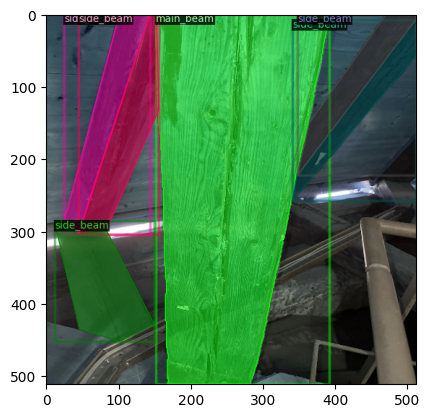

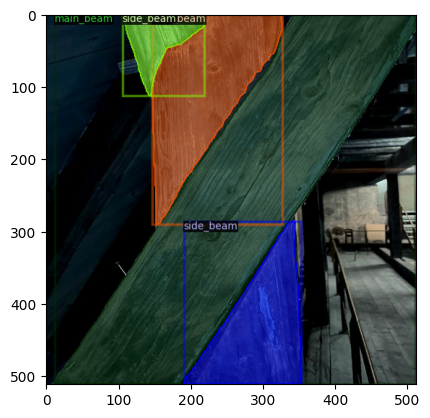

In [18]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

In [52]:
from detectron2.engine import DefaultTrainer

project_name="detectron2"
task_name="test_7_0605"

cfg = get_cfg()
# cfg.OUTPUT_DIR = r"B:\01_Study\UBWood\Project_process\P2_Experiments\202406_Detectron2\test_2_0602"
cfg['OUTPUT_DIR'] = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}"
output_directory = cfg['OUTPUT_DIR']
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wood_train",)
cfg.DATASETS.TEST = ("wood_val",)
cfg.DATALOADER.NUM_WORKERS = 2 # number of data loading threads
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16 # images per batch
cfg.SOLVER.BASE_LR = 0.00025 # learning rate
cfg.SOLVER.POLY_POWER = 1  # Set poly power to 1 to keep the learning rate nearly constant
cfg.SOLVER.MAX_ITER = 4174 # iterations
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

# save the configuration
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}/config.yaml"

directory = os.path.dirname(config_yaml_path)

if not os.path.exists(directory):
    os.makedirs(directory)

with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

[06/05 17:07:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

In [53]:
#clearml mac
# %env CLEARML_WEB_HOST=https://app.clear.ml
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=QO1VBBX9J2S2VYILQTGI
# %env CLEARML_API_SECRET_KEY=ERuc1S6o5SirQGugvYXDFjH9b9aNi0u8S3rpALzXMa8YPSLDMW

# clearml win
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
%env CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn

from clearml import Task

#Clear ML Initialization
cl_task = Task.init(project_name=project_name,task_name=task_name)
logger = cl_task.get_logger()

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
env: CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn


Could not read Jupyter Notebook: No module named 'nbconvert'
Please install nbconvert using "pip install nbconvert"


ClearML Task: created new task id=e9bcdbe9e4844f858138f622c5e00d11
ClearML results page: https://app.clear.ml/projects/74b6e0a691274f3ab5c4d4c07b606bd2/experiments/e9bcdbe9e4844f858138f622c5e00d11/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [54]:
trainer.train() #Start the training process
cl_task.close()

[06/05 17:07:45 d2.engine.train_loop]: Starting training from iteration 0
[06/05 17:08:07 d2.utils.events]:  eta: 1:15:48  iter: 19  total_loss: 3.063  loss_cls: 1.461  loss_box_reg: 0.2294  loss_mask: 0.6928  loss_rpn_cls: 0.4988  loss_rpn_loc: 0.1503    time: 1.1083  last_time: 1.1002  data_time: 0.2418  last_data_time: 0.2176   lr: 4.9953e-06  max_mem: 12281M
[06/05 17:08:29 d2.utils.events]:  eta: 1:15:43  iter: 39  total_loss: 2.995  loss_cls: 1.31  loss_box_reg: 0.2801  loss_mask: 0.6898  loss_rpn_cls: 0.5656  loss_rpn_loc: 0.1579    time: 1.1068  last_time: 1.0759  data_time: 0.2276  last_data_time: 0.2181   lr: 9.9902e-06  max_mem: 12281M
[06/05 17:08:51 d2.utils.events]:  eta: 1:15:24  iter: 59  total_loss: 2.489  loss_cls: 0.9903  loss_box_reg: 0.2792  loss_mask: 0.6833  loss_rpn_cls: 0.3899  loss_rpn_loc: 0.1075    time: 1.1065  last_time: 1.1276  data_time: 0.2302  last_data_time: 0.2497   lr: 1.4985e-05  max_mem: 12281M
[06/05 17:09:14 d2.utils.events]:  eta: 1:15:40  iter

# Inference & evaluation using the trained model

In [55]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/05 19:00:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/test_7_0605/model_final.pth ...


Verify segmentation on random validation images

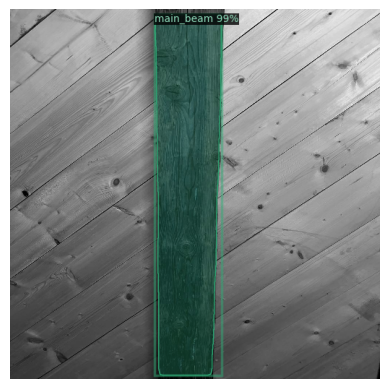

In [70]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::-1])
    
    plt.axis('off')
    
    original_file_name = os.path.basename(d["file_name"])
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(cfg.OUTPUT_DIR, new_file_name)
    plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0)

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [51]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wood_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "wood_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/05 17:03:35 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/05 17:03:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/05 17:03:35 d2.data.datasets.coco]: Loaded 107 images in COCO format from /mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json
[06/05 17:03:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/05 17:03:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/05 17:03:35 d2.data.common]: Serializing 107 elements to byte tensors and concatenating them all ...
[06/05 17:03:35 d2.data.common]: Serialized dataset takes 0.36 MiB
[06/05 17:03:35 d2.evaluation.evaluator]: Start inference on 107 batches
[06/05 17:03:35 d2

**Load a new image and segment it.**

In [ ]:
new_im = cv2.imread(r"B:\01_Study\Uni-Bamberg\Work\Holzprojects\Datasets_local\03_Domini_ip13\Dominik-seg.v4i.coco-segmentation\test\Model_5_0016_jpeg.rf.04622e1c6175ec13b0be7f653916a02d.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])

**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


**Segment images and save object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label


# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")


**Generate plots to understand the objects**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results/output_objects.csv"  # Update with your CSV file path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()




**Saving binary (actually multinary) images for each class for further processing.** Here, for each input image we will save n images corresponding to the number of classes. In our example, we will save 4 images for each image corresponding to the 4 classes. Each of these images will contain objects numbered 1, 2, 3, etc. - basically instance segmentation like images. These images can be used for further downstream processing.

In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results_instance"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")


# END

**Interested in panoptic segmentation?**

In [ ]:
my_new_image = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/street_small.jpg")
cv2_imshow(my_new_image)

In [ ]:
# Inference with instance segmentation
cfg_inst = get_cfg()
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg_inst)
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

**Panoptic segmentation = Instance segmentation + Semantic Segmentation**





In [ ]:
# Inference with a panoptic segmentation model
cfg_pan = get_cfg()
cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_pan.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg_pan)
panoptic_seg, segments_info = predictor(new_im)["panoptic_seg"]
v = Visualizer(new_im[:, :, ::-1], MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.imshow(out.get_image()[:, :, ::-1])